# Integer Programs

In [1]:
# This code cell installs packages on Colab

import sys
if "google.colab" in sys.modules:
    !wget "https://raw.githubusercontent.com/ndcbe/optimization/main/notebooks/helper.py"
    import helper
    helper.easy_install()
else:
    sys.path.insert(0, '../')
    import helper
helper.set_plotting_style()

## Optimizing Across Process Alternatives

Reference: Example 15.3 from Biegler, Grossmann, Westerberg (1997). [See handout](../../handouts/ip_handout.pdf)

Assume that we have the choice of selecting two reactors (shown below) for the reaction $A \rightarrow B$. Reactor I has a higher conversation (80%) but it is more expensive; reactor II has a lower conversion (66.7%) but is cheaper. The cost of feed $A$ is \$5/kmol. Which process alternative (reactor I, reactor II, or both) has the minimum costs to make 10 kmol/hr of product B?

Let $x_r$ be the size (flowrate into) of reactor $r$.

Continuous cost model: $C = \underbrace{c_r (x_r)^{0.6}}_{\text{reactor}} + \underbrace{5.0 x_r}_{\text{feed}}$

### Develop the Optimization Model

**Draw a Picture**

```{tikz}

\begin{tikzpicture}
    % Reactor Boxes
    \draw (0,2) rectangle (2,3) node[pos=.5] {Reactor I};
    \draw (0,0) rectangle (2,1) node[pos=.5] {Reactor II};

    % Labels A and B
    \node at (-3.5, 1.5) {A};
    \node at (6.5, 1.5) {B};

    % Arrows and flows
    \draw[->] (-3, 1.5) -- (-2, 1.5) node[midway, above]{$x_0$} ;
    \draw[->] (-2,1.5) -- (-1,2.5);
    \draw[->] (-2,1.5) -- (-1,0.5);
    \draw[->] (-1,2.5) -- (0,2.5) node[midway, above] {$x_1$};
    \draw[->] (-1,0.5) -- (0,0.5) node[midway, above] {$x_2$};
    \draw[->] (2,2.5) -- (3,2.5) node[midway, above] {$z_1$};
    \draw[->] (2,0.5) -- (3,0.5) node[midway, above] {$z_2$};
    \draw[->] (3,2.5) -- (4,1.5);
    \draw[->] (3,0.5) -- (4,1.5);
    \draw[->] (4,1.5) -- (6,1.5) node[midway, above] {10 kmol/hr};

\end{tikzpicture}

```

**Sets**

```{dropdown} Click to expand
Reactors: $\mathcal{R} = \{1,2\}$
```

**Parameters**

```{dropdown} Click to expand

**Reactor cost coefficient**: $c_r$

$c_1 = 5.5$ $\frac{\$}{\text{hr}}$

$c_2 = 4.0$ $\frac{\$}{\text{hr}}$

**Reactor conversion**: $\theta_r$

$\theta_1 = 0.8$

$\theta_2 = 0.67$

**Feed cost**: $\Omega = 5$ $\frac{\$}{\text{kmol}}$

**Product flowrate**: $F = 10$ $\frac{\text{kmol}}{\text{hr}}$
```

**Variables**

```{dropdown} Click to expand
* Total feed flowrate: $x_0$
* Reactor feed flowrate: $x_r, \quad \forall r \in \mathcal{R}$
* Reactor effluent: $z_r, \quad \forall r \in \mathcal{R}$
```


**Objective**

```{dropdown} Click to expand

Minimize Total Cost


$ C = \sum_{r \in \mathcal{R}} c_r (x_r)^{0,6} + \Omega x_0 = \underbrace{5.5 (x_1)^{0.6}}_{\text{reactor I}} + \underbrace{4.0 (x_2)^{0.6}}_{\text{reactor II}} + \underbrace{5.0 x_0}_{\text{feed}}$

```

**Constraints**

```{dropdown} Click to expand

**Reaction**: $A \rightarrow B$

**Mass Balances**:

Initial split : $x_0 = x_1 + x_2$

Reactors (using set notation): $z_r = \theta_r x_r, \quad \forall r \in \mathcal{R}$

Reactor I: $z_1 = \underbrace{0.8}_{\theta_1} x_1$

Reactor II: $z_2 = \underbrace{0.67}_{\theta_2} x_2$

Final mixer: $z_1 + z_2 = \underbrace{10}_{F}$

**Bounds**:

$x_i \geq 0, \quad \forall r \in \mathcal{R}$

$z_i \geq 0, \quad \forall r \in \mathcal{R}$
```

**Degree of Freedom Analysis**

```{dropdown} Click to expand
Continuous variables: 5

Equality constraints: 4
```


### Solve with Continuous Cost Model in Pyomo

We start my defining the model in Pyomo.

In [2]:
import pyomo.environ as pyo

nlp = pyo.ConcreteModel()

## Define sets
nlp.REACTORS = pyo.Set(initialize=range(1,3))

## Define parameters (data)

# $ / hr
cost_coefficient = {1:5.5, 2:4.0}
nlp.reactor_cost = pyo.Param(nlp.REACTORS, initialize=cost_coefficient)

# kmol/hr B
nlp.product_flowrate = pyo.Param(initialize=10.0)

# conversion fraction
reactor_conversion = {1:0.8, 2:0.67}
nlp.conversion = pyo.Param(nlp.REACTORS, initialize=reactor_conversion)

# feed cost, $/kmol of A
nlp.feed_cost = pyo.Param(initialize=5.0)


## Define variables

# Feed flowrate into reactor, x0 in handout illustration
nlp.feed_flowrate = pyo.Var(domain=pyo.NonNegativeReals)

# Reactor feed, x1 and x2 in handout illustration
nlp.reactor_feed = pyo.Var(nlp.REACTORS, domain=pyo.NonNegativeReals)

# Reactor effluent (outlet), z1 and z2 in handout illustration
nlp.reactor_effluent = pyo.Var(nlp.REACTORS, domain=pyo.NonNegativeReals)

## Define constraints

# Add your solution here

## Define objective
nlp.cost = pyo.Objective(expr=sum(nlp.reactor_cost[r] * (nlp.reactor_feed[r])**(0.6) for r in nlp.REACTORS) +
                        nlp.feed_cost * nlp.feed_flowrate)

nlp.pprint()

1 Set Declarations
    REACTORS : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    2 : {1, 2}

4 Param Declarations
    conversion : Size=2, Index=REACTORS, Domain=Any, Default=None, Mutable=False
        Key : Value
          1 :   0.8
          2 :  0.67
    feed_cost : Size=1, Index=None, Domain=Any, Default=None, Mutable=False
        Key  : Value
        None :   5.0
    product_flowrate : Size=1, Index=None, Domain=Any, Default=None, Mutable=False
        Key  : Value
        None :  10.0
    reactor_cost : Size=2, Index=REACTORS, Domain=Any, Default=None, Mutable=False
        Key : Value
          1 :   5.5
          2 :   4.0

3 Var Declarations
    feed_flowrate : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  None :  None : False :  True : NonNegativeReals
    reactor_effluent : Size=2, Index=REACTORS
        Key : Lower : Value : Upper : Fixed : S

```{dropdown} Click to seel the solution to the activity

```python
# mass balance over splitter
nlp.inlet_split = pyo.Constraint(expr=nlp.feed_flowrate == sum(nlp.reactor_feed[r] for r in nlp.REACTORS))

# reactor conversion
def rule_reactor(m, r):
    return m.reactor_effluent[r] == m.conversion[r] * m.reactor_feed[r]
nlp.reactor_performance = pyo.Constraint(nlp.REACTORS, rule=rule_reactor)

# mass balance over mixer meets product requirements
nlp.mixer = pyo.Constraint(expr=nlp.product_flowrate == sum(nlp.reactor_effluent[r] for r in nlp.REACTORS))

### Initialize to Favor Reaction 1 and Solve

In [3]:
def initialize(model, reactor_choice=1):
    ''' Initialize all of the variables in the model to demonstrate local solutions
    
    Arguments:
        model: Pyomo model
        reactor_choice: 1 or 2
    
    Returns:
        nothing
        
    Action:
        initializes model
    
    '''
    
    # Guess 20 kmol/hr feed of A
    model.feed_flowrate = 20.0
    
    # Either assign all of the feed to reactor 1 or 2
    if reactor_choice == 1:
        model.reactor_feed[1] = 20.0
        model.reactor_feed[2] = 0
    elif reactor_choice == 2:
        model.reactor_feed[1] = 0
        model.reactor_feed[2] = 20.0
    else:
        raise ValueError("Argument reactor_choice needs value 1 or 2.")
    
    # Based on the feed assignments, calculate effluent flowrate
    for r in model.REACTORS:
        model.reactor_effluent[r] = model.reactor_feed[r]() * model.conversion[r]
    
initialize(nlp, reactor_choice=1)
nlp.pprint()

1 Set Declarations
    REACTORS : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    2 : {1, 2}

4 Param Declarations
    conversion : Size=2, Index=REACTORS, Domain=Any, Default=None, Mutable=False
        Key : Value
          1 :   0.8
          2 :  0.67
    feed_cost : Size=1, Index=None, Domain=Any, Default=None, Mutable=False
        Key  : Value
        None :   5.0
    product_flowrate : Size=1, Index=None, Domain=Any, Default=None, Mutable=False
        Key  : Value
        None :  10.0
    reactor_cost : Size=2, Index=REACTORS, Domain=Any, Default=None, Mutable=False
        Key : Value
          1 :   5.5
          2 :   4.0

3 Var Declarations
    feed_flowrate : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  20.0 :  None : False : False : NonNegativeReals
    reactor_effluent : Size=2, Index=REACTORS
        Key : Lower : Value : Upper : Fixed : S

Now let's solve the model.

In [4]:
solver = pyo.SolverFactory('ipopt')
results = solver.solve(nlp, tee=True)

Error evaluating "var =" definition -1: can't evaluate pow'(0,0.6).
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortr

ApplicationError: Solver (ipopt) did not exit normally

What happened? $0^{0.6}$ is not well defined. Work around? Let's set the lower bound to something really small:

In [5]:
small_number = 1E-6
for r in nlp.REACTORS:
    
    # Set lower bound
    nlp.reactor_feed[r].setlb(small_number)
    
    # Adjust initial point if needed
    nlp.reactor_feed[r] = max(nlp.reactor_feed[r](), small_number)
    
nlp.pprint()

1 Set Declarations
    REACTORS : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    2 : {1, 2}

4 Param Declarations
    conversion : Size=2, Index=REACTORS, Domain=Any, Default=None, Mutable=False
        Key : Value
          1 :   0.8
          2 :  0.67
    feed_cost : Size=1, Index=None, Domain=Any, Default=None, Mutable=False
        Key  : Value
        None :   5.0
    product_flowrate : Size=1, Index=None, Domain=Any, Default=None, Mutable=False
        Key  : Value
        None :  10.0
    reactor_cost : Size=2, Index=REACTORS, Domain=Any, Default=None, Mutable=False
        Key : Value
          1 :   5.5
          2 :   4.0

3 Var Declarations
    feed_flowrate : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  20.0 :  None : False : False : NonNegativeReals
    reactor_effluent : Size=2, Index=REACTORS
        Key : Lower : Value : Upper : Fixed : S

Now let's resolve:

In [6]:
solver = pyo.SolverFactory('ipopt')
results = solver.solve(nlp, tee=True)

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

Now we can print the variable names and values:

In [7]:
def print_solution(model):
    '''Print variable names and values
    
    Arguments:
        model: Pyomo model
    
    '''

    print("Variable Names\t\tValue")
    for c in model.component_data_objects(pyo.Var):
        print(c.name,"\t\t", pyo.value(c))
        
    print("\nObjective Name\t\tValue")
    for c in model.component_data_objects(pyo.Objective):
        print(c.name,"\t\t", pyo.value(c))
        
print_solution(nlp)

Variable Names		Value
feed_flowrate 		 12.500000160876471
reactor_feed[1] 		 12.499999170867413
reactor_feed[2] 		 1e-06
reactor_effluent[1] 		 9.99999933669393
reactor_effluent[2] 		 6.633060682547189e-07

Objective Name		Value
cost 		 87.53376235430073


### Initialize to Favor Reaction 2 and Solve

In [8]:
# Initialize
initialize(nlp, reactor_choice=2)

# Correct for bound
# Note: I would have put this in the initialize function but I wanted to show
# the error in class
for r in nlp.REACTORS:
    # Adjust initial point if needed
    nlp.reactor_feed[r] = max(nlp.reactor_feed[r](), small_number)

results = solver.solve(nlp, tee=True)
print_solution(nlp)

WARNING (W1002): Setting Var 'reactor_feed[1]' to a numeric value `0` outside
the bounds (1e-06, None).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the

### Compare Solutions

| | Solution 1 | Solution 2 |
| -- | -- | -- |
| Feed Flowrate (kmol/hr) | 12.50 | 14.93 | 
| Reactor 1 Feed (kmol/hr) | 12.50 | 0 |
| Reactor 2 Feed (kmol/hr) | 0 | 14.93 |
| Reactor 1 Effluent (kmol/hr) | 10.00 | 0 |
| Reactor 2 Effluent (kmol/hr) | 0 | 10.00 |
| Cost (\$/hr) | 87.54 | 94.88 |

Which solution is better? Why are there multiple solutions?

### Linearized Discrete Cost Model

We want to modify the model to:
* Easily find the best global solution (reduce impacts of initialization)
* Account for the fact there is a minimum reactor size we can purchase

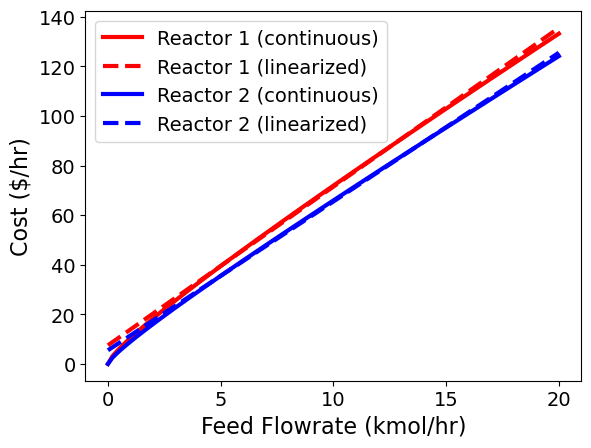

In [16]:
import matplotlib.pyplot as plt
import numpy as np

feed = np.linspace(0, 20, 101)

for reactor in [1, 2]:

    if reactor == 1:
        c = 5.5
        c_linear = 6.4
        c_fixed = 7.5
        c_feed = 5
        color = 'r'
    elif reactor == 2:
        c = 4.0
        c_linear = 6.0
        c_fixed = 5.5
        color = 'b'
    else:
        break

    cost_continous = c*(feed)**(0.6) + c_feed*feed
    cost_linearized = c_linear*feed + c_fixed

    plt.plot(feed, cost_continous, label="Reactor " + str(reactor) + " (continuous)", color=color, linestyle='-')
    plt.plot(feed, cost_linearized, label="Reactor " + str(reactor) + " (linearized)", color=color, linestyle='--')

plt.legend()
plt.xlabel('Feed Flowrate (kmol/hr)')
plt.ylabel('Cost (\$/hr)')
plt.show()




Define binary variable:

$
y_r = \begin{cases}
1 & \text{if reactor } r \text{ is selected} \\
0 & \text{otherwise}
\end{cases}
$

Add logical constraints to include the maximum flowrate (20 kmol/hr):

$
x_r \leq 20 y_r, \quad \forall r \in \mathcal{R}
$

Thus if $y_r = 0$, then $x_r = 0$

Finally, we can define the new linearized reactor cost model:

\begin{align*}
\text{Reactor I:} \quad & 7.5 y_1 + 1.4 x_1 \\
\text{Reactor II:} \quad & 5.5 y_2 + 1.0 x_2
\end{align*}

Recall that $x_0 = x_1 + x_2$. Thus, the feed cost is $5x_0 = 5 x_1 + 5 x_2$.

Putting this all together gives the following MILP optimization problem:

\begin{align*}
\min_{x,y} \quad & C = 7.5 y_1 + 6.4 x_1 + 5.5 y_2 + 6.0 x_2 \\
\text{s.t.} \quad & 0.8 x_1 + 0.67 x_2 = 10 \\
& x_1 - 20 y_1 \leq 0 \\
& x_2 - 20 y_2 \leq 0 \\
& x_1, x_2 \geq 0, \quad y_1, y_2 \in \{0, 1\}
\end{align*}



### Enumerate the solutions

As an illustration, enumerate through the following four options:
1. No reactor
2. Reactor I only
3. Reactor II only
4. Reactor I and II only

For each option, ask:
* Are the constraints feasible?
* What is the objective?

| Reactor 1 | Reactor 2 | Cost |
| -- | -- | -- |
| 0 | 0 | infeasible |
| 1 | 0 | 87.5 |
| 0 | 1 | 95.5 |
| 1 | 1 | 93.0 |


### Solve with Pyomo

Create and inspect the model.

In [10]:
milp = pyo.ConcreteModel()

## Define sets
milp.REACTORS = pyo.Set(initialize=range(1,3))

## Define parameters (data)

# kmol/hour
milp.max_flowrate = pyo.Param(initialize=20.0)

# $ / hr
# note: this includes the 5.0 linear feed cost
cost_coefficient1 = {1:6.4, 2:6.0}
milp.reactor_cost_linear = pyo.Param(milp.REACTORS, initialize=cost_coefficient1)

# $
cost_coefficient2 = {1:7.5, 2:5.5}
milp.reactor_cost_fixed = pyo.Param(milp.REACTORS, initialize=cost_coefficient2)

# kmol/hr B
milp.product_flowrate = pyo.Param(initialize=10.0)

# conversion fraction
reactor_conversion = {1:0.8, 2:0.67}
milp.conversion = pyo.Param(milp.REACTORS, initialize=reactor_conversion)

# feed cost, $/kmol of A
milp.feed_cost = pyo.Param(initialize=5.0)


## Define variables

# Feed flowrate into reactor, x0 in handout illustration
milp.feed_flowrate = pyo.Var(domain=pyo.NonNegativeReals, bounds=(0, milp.max_flowrate))

# Reactor feed, x1 and x2 in handout illustration
milp.reactor_feed = pyo.Var(milp.REACTORS, domain=pyo.NonNegativeReals, bounds=(0, milp.max_flowrate))

# Reactor effluent (outlet), z1 and z2 in handout illustration
milp.reactor_effluent = pyo.Var(milp.REACTORS, domain=pyo.NonNegativeReals)

# Boolean variables
# Add your solution here

## Define constraints

# mass balance over splitter
milp.inlet_split = pyo.Constraint(expr=milp.feed_flowrate == sum(milp.reactor_feed[r] for r in milp.REACTORS))

# reactor conversion
def rule_reactor(m, r):
    return m.reactor_effluent[r] == m.conversion[r] * m.reactor_feed[r]
milp.reactor_performance = pyo.Constraint(milp.REACTORS, rule=rule_reactor)

# mass balance over mixer meets product requirements
milp.mixer = pyo.Constraint(expr=milp.product_flowrate == sum(milp.reactor_effluent[r] for r in milp.REACTORS))

# logical constraints
# Add your solution here

## Define objective
# Note: our linearization already includes feed costs
# Add your solution here
milp.pprint()

1 Set Declarations
    REACTORS : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    2 : {1, 2}

6 Param Declarations
    conversion : Size=2, Index=REACTORS, Domain=Any, Default=None, Mutable=False
        Key : Value
          1 :   0.8
          2 :  0.67
    feed_cost : Size=1, Index=None, Domain=Any, Default=None, Mutable=False
        Key  : Value
        None :   5.0
    max_flowrate : Size=1, Index=None, Domain=Any, Default=None, Mutable=False
        Key  : Value
        None :  20.0
    product_flowrate : Size=1, Index=None, Domain=Any, Default=None, Mutable=False
        Key  : Value
        None :  10.0
    reactor_cost_fixed : Size=2, Index=REACTORS, Domain=Any, Default=None, Mutable=False
        Key : Value
          1 :   7.5
          2 :   5.5
    reactor_cost_linear : Size=2, Index=REACTORS, Domain=Any, Default=None, Mutable=False
        Key : Value
          1 :   6.4
          2 :   6.0

4 Var De

```{dropdown} Click to seel the solution to the activity

```python
# Boolean variables
milp.reactor_boolean = pyo.Var(milp.REACTORS, domain=pyo.Boolean)

# logical constraints
def rule_toggle_reactor(m, r):
    return m.reactor_feed[r] <= m.reactor_boolean[r] * m.max_flowrate
milp.toggle_reactor = pyo.Constraint(milp.REACTORS, rule=rule_toggle_reactor)

# objective
milp.cost = pyo.Objective(expr=sum(milp.reactor_cost_linear[r] * milp.reactor_feed[r] + 
                                   milp.reactor_cost_fixed[r] * milp.reactor_boolean[r]
                                   for r in milp.REACTORS) )

Solve the model using `cbc`, `bonmin`, `gurobi` (need license), or `cplex` (need license).

In [11]:

# Set solver
# solver = pyo.SolverFactory('gurobi')
# solver = pyo.SolverFactory('glpk')
solver = pyo.SolverFactory('cbc')
# solver = pyo.SolverFactory('bonmin')

# Add your solution here

print_solution(milp)

Welcome to the CBC MILP Solver 
Version: 2.10.5 
Build Date: Apr 19 2021 

command line - /Users/adowling/anaconda3/envs/controls/bin/cbc -printingOptions all -import /var/folders/8v/lbvy4xb128d687t1pwzl_cfh0000gp/T/tmprnx7qg9n.pyomo.lp -stat=1 -solve -solu /var/folders/8v/lbvy4xb128d687t1pwzl_cfh0000gp/T/tmprnx7qg9n.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 2 (-4) rows, 3 (-4) columns and 4 (-9) elements
Statistics for presolved model
Original problem has 2 integers (2 of which binary)
Presolved problem has 2 integers (2 of which binary)
==== 0 zero objective 3 different
1 variables have objective of 0.64
1 variables have objective of 5.5
1 variables have objective of 7.5
==== absolute objective values 3 different
1 variables have objective of 0.64
1 variables have objective of 5.5
1 variables have objective of 7.5
==== for integers 0 zero objective 2 different
1 variables have objective of 5.5
1 variables have objective of 7.5
====

## Is rounding good enough?

### Linear Program (Relaxation)

$$\begin{align}\min_{x_1,x_2} \quad & x_2 \\
\mathrm{s.t.} \quad & 2 x_1 + x_2 \geq 13 \\
& 5 x_1 + 2 x_2 \leq 30 \\
& -x_1 + x_2 \geq 5 \\
& x_1, x_2 \geq 0
\end{align}$$

In [12]:
import pyomo.environ as pyo

m = pyo.ConcreteModel()

# Declare variables with bounds
m.x1 = pyo.Var(domain=pyo.NonNegativeReals)
m.x2 = pyo.Var(domain=pyo.NonNegativeReals)

# Constraint 1
m.con1 = pyo.Constraint(expr=2*m.x1 + m.x2 >= 13)

# Constraint 2
m.con2 = pyo.Constraint(expr=5*m.x1 + 2*m.x2 <= 30)

# Constraint 3
m.con3 = pyo.Constraint(expr=-m.x1 + m.x2 >= 5)

# Objective
m.obj = pyo.Objective(expr=m.x2)

# Print model
m.pprint()

2 Var Declarations
    x1 : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  None :  None : False :  True : NonNegativeReals
    x2 : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  None :  None : False :  True : NonNegativeReals

1 Objective Declarations
    obj : Size=1, Index=None, Active=True
        Key  : Active : Sense    : Expression
        None :   True : minimize :         x2

3 Constraint Declarations
    con1 : Size=1, Index=None, Active=True
        Key  : Lower : Body      : Upper : Active
        None :  13.0 : 2*x1 + x2 :  +Inf :   True
    con2 : Size=1, Index=None, Active=True
        Key  : Lower : Body        : Upper : Active
        None :  -Inf : 5*x1 + 2*x2 :  30.0 :   True
    con3 : Size=1, Index=None, Active=True
        Key  : Lower : Body      : Upper : Active
        None :   5.0 : - x1 + x2 :  +Inf :   True

6 Declarations: x1 x2 con1 con2 con3

In [13]:
# Set solver
# solver = pyo.SolverFactory('gurobi')
# solver = pyo.SolverFactory('glpk')
# solver = pyo.SolverFactory('ipopt')\
solver = pyo.SolverFactory('cbc')


# Solve
solver.solve(m,tee=True)

# Print solution
print(" ")
print("x1 = ",pyo.value(m.x1))
print("x2 = ",pyo.value(m.x2))

Welcome to the CBC MILP Solver 
Version: 2.10.5 
Build Date: Apr 19 2021 

command line - /Users/adowling/anaconda3/envs/controls/bin/cbc -printingOptions all -import /var/folders/8v/lbvy4xb128d687t1pwzl_cfh0000gp/T/tmp936ikgx2.pyomo.lp -stat=1 -solve -solu /var/folders/8v/lbvy4xb128d687t1pwzl_cfh0000gp/T/tmp936ikgx2.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 3 (0) rows, 2 (0) columns and 6 (0) elements
Statistics for presolved model


Problem has 3 rows, 2 columns (1 with objective) and 6 elements
Column breakdown:
2 of type 0.0->inf, 0 of type 0.0->up, 0 of type lo->inf, 
0 of type lo->up, 0 of type free, 0 of type fixed, 
0 of type -inf->0.0, 0 of type -inf->up, 0 of type 0.0->1.0 
Row breakdown:
0 of type E 0.0, 0 of type E 1.0, 0 of type E -1.0, 
0 of type E other, 0 of type G 0.0, 0 of type G 1.0, 
2 of type G other, 0 of type L 0.0, 0 of type L 1.0, 
1 of type L other, 0 of type Range 0.0->1.0, 0 of type Range other, 
0 of type

### Rounding

With your neighbor, discuss:
* If you round $x_1$ and $x_2$ to an integer, are all of the constraints feasible?
* How would you go about checking the optimality of a feasible integer solution?

### Integer Program

Consider the following integer program:

$$\begin{align}\min_{x_1,x_2} \quad & x_2 \\
\mathrm{s.t.} \quad & 2 x_1 + x_2 \geq 13 \\
& 5 x_1 + 2 x_2 \leq 30 \\
& -x_1 + x_2 \geq 5 \\
& x_1, x_2 \in \mathcal{Z} := \{0,1,2,...\}
\end{align}$$

In [14]:
m2 = pyo.ConcreteModel()

# Declare variables as positive integers
m2.x1 = pyo.Var(domain=pyo.PositiveIntegers)
m2.x2 = pyo.Var(domain=pyo.PositiveIntegers)

# Constraint 1
m2.con1 = pyo.Constraint(expr=2*m2.x1 + m2.x2 >= 13)

# Constraint 2
m2.con2 = pyo.Constraint(expr=5*m2.x1 + 2*m2.x2 <= 30)

# Constraint 3
m2.con3 = pyo.Constraint(expr=-m2.x1 + m2.x2 >= 5)

# Objective
m2.obj = pyo.Objective(expr=m2.x2)

m2.pprint()

2 Var Declarations
    x1 : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     1 :  None :  None : False :  True : PositiveIntegers
    x2 : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     1 :  None :  None : False :  True : PositiveIntegers

1 Objective Declarations
    obj : Size=1, Index=None, Active=True
        Key  : Active : Sense    : Expression
        None :   True : minimize :         x2

3 Constraint Declarations
    con1 : Size=1, Index=None, Active=True
        Key  : Lower : Body      : Upper : Active
        None :  13.0 : 2*x1 + x2 :  +Inf :   True
    con2 : Size=1, Index=None, Active=True
        Key  : Lower : Body        : Upper : Active
        None :  -Inf : 5*x1 + 2*x2 :  30.0 :   True
    con3 : Size=1, Index=None, Active=True
        Key  : Lower : Body      : Upper : Active
        None :   5.0 : - x1 + x2 :  +Inf :   True

6 Declarations: x1 x2 con1 con2 con3

In [15]:
# Set solver
# solver = pyo.SolverFactory('gurobi')
# solver = pyo.SolverFactory('glpk')
solver = pyo.SolverFactory('cbc')
# solver = pyo.SolverFactory('bonmin')

# Solve
solver.solve(m2,tee=True)

# Print solution
print(" ")
print("x1 = ",m2.x1())
print("x2 = ",m2.x2())

Welcome to the CBC MILP Solver 
Version: 2.10.5 
Build Date: Apr 19 2021 

command line - /Users/adowling/anaconda3/envs/controls/bin/cbc -printingOptions all -import /var/folders/8v/lbvy4xb128d687t1pwzl_cfh0000gp/T/tmpclopbyat.pyomo.lp -stat=1 -solve -solu /var/folders/8v/lbvy4xb128d687t1pwzl_cfh0000gp/T/tmpclopbyat.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 3 (0) rows, 2 (0) columns and 6 (0) elements
Statistics for presolved model
Original problem has 2 integers (0 of which binary)
==== 1 zero objective 2 different
1 variables have objective of 0
1 variables have objective of 1
==== absolute objective values 2 different
1 variables have objective of 0
1 variables have objective of 1
==== for integers 1 zero objective 2 different
1 variables have objective of 0
1 variables have objective of 1
==== for integers absolute objective values 2 different
1 variables have objective of 0
1 variables have objective of 1
===== end objective co

### Why rounding does not always work

Reference: http://personal.lse.ac.uk/williahp/publications/wp%2010-118.pdf

![feasible](https://raw.githubusercontent.com/ndcbe/optimization/main/media/feasible.png)